### Imports

In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks, regularizers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

### Helper Function

In [2]:
def save_model(model, model_version, model_name='spec_photo_model'):
    os.makedirs(f'../models/{model_version}', exist_ok=True)
    model.save(f'../models/{model_version}/{model_name}.h5')

In [3]:
def save_history(history, model_version, history_name='history'):
    os.makedirs(f'../history/{model_version}', exist_ok=True)

    history_path = os.path.join(f'../history/{model_version}', f'{history_name}.json')
    with open(history_path, 'w') as f:
        json.dump(history.history, f)

In [4]:
def load_model(model_version, model_name='spec_photo_model'):
    model_path = f'../models/{model_version}/{model_name}.h5'
    if os.path.exists(model_path):
        return keras.models.load_model(model_path)
    else:
        raise FileNotFoundError(f"Model file {model_path} does not exist.")

In [5]:
def load_history(model_version, history_name='history'):
    """
    Load training history from a file.

    Parameters:
        model_version (str): Version of the model.
        history_name (str): Name of the history file (without extension).

    Returns:
        dict: Training history dictionary.
    """
    history_path = f'../history/{model_version}/{history_name}.json'
    if os.path.exists(history_path):
        with open(history_path, 'r') as f:
            history = json.load(f)
        return history
    else:
        raise FileNotFoundError(f"History file {history_path} does not exist.")

In [6]:
def plot_metrics(y_test, y_pred, threshold=0.2):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Dex accuracy metrics (since inputs are already in log space)
    mae_dex = mae  # identical unless you're converting from linear scale
    rmse_dex = rmse

    # Fraction of predictions within ±threshold dex
    within_tolerance = np.mean(np.abs(y_pred - y_test) <= threshold)

    print(f"📊 Evaluation Metrics:")
    print(f"Mean Absolute Error (MAE): {mae_dex:.4f} dex")
    print(f"Root Mean Squared Error (RMSE): {rmse_dex:.4f} dex")
    print(f"R² Score: {r2:.4f}")
    print(f"Fraction within ±{threshold:.2f} dex: {within_tolerance:.2%}")

In [7]:
def plot_visualizations(y_test, y_pred, z_values=None, history=None):
    y_pred_flat = y_pred.ravel() if y_pred.ndim > 1 else y_pred

    if hasattr(y_test, 'iloc') and isinstance(y_test, pd.DataFrame):
        y_test_array = y_test.iloc[:, 0].values
    else:
        y_test_array = np.array(y_test)

    y_test_flat = y_test_array.ravel() if y_test_array.ndim > 1 else y_test_array
    residuals = y_test_flat - y_pred_flat

    # Residual Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_pred_flat,
            residuals,
            c=z_values,
            cmap='viridis',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_pred_flat, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot (Colored by Redshift)" if z_values is not None else "Residual Plot")
    plt.tight_layout()
    plt.show()

    # Parity Plot
    plt.figure(figsize=(8, 5))
    if z_values is not None:
        scatter = plt.scatter(
            y_test_flat,
            y_pred_flat,
            c=z_values,
            cmap='plasma',
            alpha=0.6,
            edgecolors='w',
            linewidth=0.3
        )
        plt.colorbar(scatter, label='Redshift (z)')
    else:
        sns.scatterplot(x=y_test_flat, y=y_pred_flat, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Parity Plot (Colored by Redshift)" if z_values is not None else "Parity Plot")
    plt.tight_layout()
    plt.show()

    # Residual Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.title("Distribution of Prediction Errors")
    plt.tight_layout()
    plt.show()

    if history is not None:
        # Determine if history is a dictionary or a Keras History object
        _history = None
        if isinstance(history, dict):
            _history = history
        elif hasattr(history, 'history'):
            _history = history.history
        else:
            raise ValueError("Invalid history object provided. It should be a dictionary or a Keras History object.")
        
        # Training vs Validation Loss
        plt.figure(figsize=(8, 4))
        plt.plot(_history['loss'], label='Training Loss', color='steelblue')
        plt.plot(_history['val_loss'], label='Validation Loss', color='salmon')
        plt.xlabel("Epochs")
        plt.ylabel("Mean Squared Error")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Training vs Validation MAE
        plt.figure(figsize=(8, 4))
        plt.plot(_history['mae'], label='Training MAE', color='darkgreen')
        plt.plot(_history['val_mae'], label='Validation MAE', color='orange')
        plt.xlabel("Epochs")
        plt.ylabel("Mean Absolute Error")
        plt.title("Training vs Validation MAE")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Data Cleaning and Preprocessing

In [ ]:
if not os.path.exists('models/'):
    os.makedirs('models/')

if not os.path.exists('output/'):
    os.makedirs('output/')

In [9]:
data = {
    "spectro_cols": [
        "h_alpha_flux", "oiii_5007_flux", "nii_6584_flux", "sii_6717_flux",
        "lick_mgb", "lick_fe5335", "d4000", "velocityDisp"
    ],
    "photometry_cols": [
        "modelMag_u", "modelMag_r", "modelMag_z", "fracDev_r", "petroRad_r",
        "extinction_u", "extinction_r", "extinction_z"
    ],
    "generic_cols": ["z", "zErr"],
    "target_col": ["logM_star"]
}
    
spectro_cols = data['spectro_cols']
photo_cols = data['photometry_cols']
generic_cols = data['generic_cols']
target_col = data['target_col']

In [10]:
if os.path.exists('data/processed/'):
    print("Data has already been processed and is ready for use.")
else:
    os.makedirs('data/processed/')
    df = pd.read_csv('data/raw/combined.csv')

    df_cleaned = df[~(df == -9999).any(axis=1)]
    df_cleaned = df_cleaned.drop_duplicates()
    df_cleaned = df_cleaned[df_cleaned['clean'] == 1]
    df_cleaned = df_cleaned[df_cleaned['type'] == 3] # type = 3 is for galaxies
    df_cleaned.drop(columns=['subClass', 'class', 'clean'], inplace=True)
    
    df = df_cleaned.copy()
    
    # --- Step 1: Log-transform emission line fluxes after clipping ---
    for col in ["h_alpha_flux", "oiii_5007_flux", "nii_6584_flux", "sii_6717_flux"]:
        df[col] = df[col].clip(lower=0)
        df[f"log_{col}"] = np.log1p(df[col])
        
    # --- Step 2: Physical filtering ---
    df = df[df["z"].between(0.00, 0.30)]
    df = df[df["zErr"] < 0.01]
    df = df[df["petroRad_r"] > 0.5]
    df = df[df["fracDev_r"].between(0, 1)]
    df = df[df["extinction_u"] < 1.5]
    
    # --- Step 3: Statistical IQR filtering ---
    def iqr_filter(data, col):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        return data[col].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

    for col in ["logM_star", "velocityDisp", "d4000"]:
        df = df[iqr_filter(df, col)]
        
    # --- Step 4: Multivariate outlier detection ---
    feature_cols = [f"log_{col}" for col in ["h_alpha_flux", "oiii_5007_flux", "nii_6584_flux", "sii_6717_flux"]] \
                   + ["lick_mgb", "lick_fe5335", "d4000", "velocityDisp"] \
                   + photo_cols + generic_cols

    df = df.dropna(subset=feature_cols)
    df_features = df[feature_cols]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(df_features)

    iso = IsolationForest(contamination=0.2, random_state=42)
    outlier_flags = iso.fit_predict(features_scaled)

    df_clean = df[outlier_flags == 1].copy()

    df_clean.to_csv('data/processed/cleaned_data.csv', index=False)

    # Splitting data into 2 parts: Spectrometry + Photometry, Photometry Only
    portions = np.array_split(df_clean, 2)

    portions[0].to_csv('data/processed/spectrometry_photometry.csv', index=False)
    portions[1].to_csv('data/processed/photometry_only.csv', index=False)
    print("Data has been processed and saved to 'data/processed/' directory.")

Data has already been processed and is ready for use.


# Method 1: Transfer Learning

### Spectometry + Photometry Base Model

In [ ]:
os.makedirs('output/spectro_photo_base_model', exist_ok=True)

In [12]:
df = pd.read_csv(f"data/processed/spectrometry_photometry.csv")

X = df[spectro_cols + photo_cols + generic_cols].copy()
y = df[target_col].copy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'output/spectro_photo_base_model/scaler.pkl')

['outputs/spectro_photo_base_model/scaler.pkl']

In [15]:
input_shape = X_train_scaled.shape[1]
optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 2
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)
x = layers.BatchNormalization(name='BatchNorm_256')(x)
x = layers.Activation('relu', name='Activation_256')(x)

# Layer 4
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)
x = layers.BatchNormalization(name='BatchNorm_128_2')(x)
x = layers.Activation('relu', name='Activation_128_2')(x)

# Layer 5
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_2')(x)
x = layers.Dropout(0.2, name='Dropout_64_2')(x)
x = layers.BatchNormalization(name='BatchNorm_64_2')(x)
x = layers.Activation('relu', name='Activation_64_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Spectro_Photo_Base_Regression_Model')

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Spectro_Photo_Base_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 18)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                1216      
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 BatchNorm_64 (BatchNormaliz  (None, 64)               256       
 ation)                                                          
                                                                 
 Activation_64 (Activation)  (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                               

In [16]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
4383/4383 [==============================] - 56s 12ms/step - loss: 3.9820 - mae: 1.0154 - mse: 3.4967 - mape: 9.5160 - val_loss: 0.4682 - val_mae: 0.3107 - val_mse: 0.1247 - val_mape: 2.9068
Epoch 2/200
4383/4383 [==============================] - 59s 13ms/step - loss: 0.4200 - mae: 0.3777 - mse: 0.2337 - mape: 3.5468 - val_loss: 0.2000 - val_mae: 0.2596 - val_mse: 0.1086 - val_mape: 2.4012
Epoch 3/200
4383/4383 [==============================] - 59s 13ms/step - loss: 0.1871 - mae: 0.2681 - mse: 0.1248 - mape: 2.5258 - val_loss: 0.0915 - val_mae: 0.1753 - val_mse: 0.0553 - val_mape: 1.6240
Epoch 4/200
4383/4383 [==============================] - 59s 13ms/step - loss: 0.0633 - mae: 0.1576 - mse: 0.0441 - mape: 1.4922 - val_loss: 0.0190 - val_mae: 0.0755 - val_mse: 0.0120 - val_mape: 0.7179
Epoch 5/200
4383/4383 [==============================] - 59s 14ms/step - loss: 0.0351 - mae: 0.1289 - mse: 0.0291 - mape: 1.2232 - val_loss: 0.0279 - val_mae: 0.1118 - val_mse: 0.0223 - va

In [ ]:
model.save('output/spectro_photo_base_model/model.h5')

In [18]:
y_pred = model.predict(X_test_scaled)

2349/2349 [==============================] - 5s 2ms/step


In [19]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0760 dex
Root Mean Squared Error (RMSE): 0.1041 dex
R² Score: 0.9552
Fraction within ±0.20 dex: 96.40%


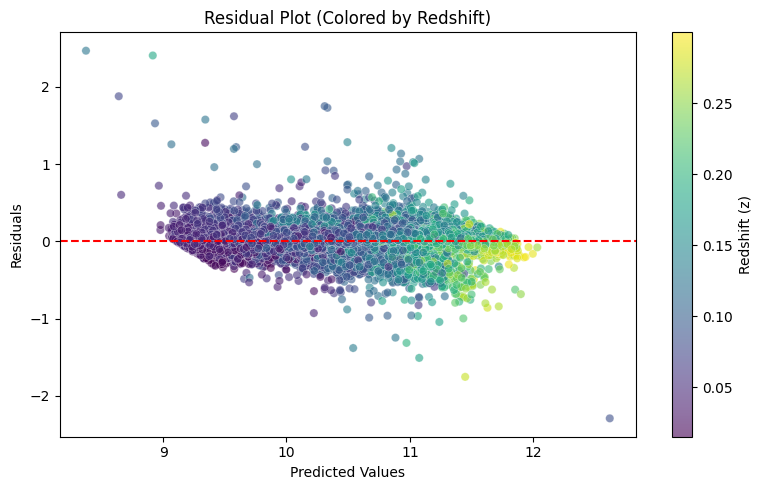

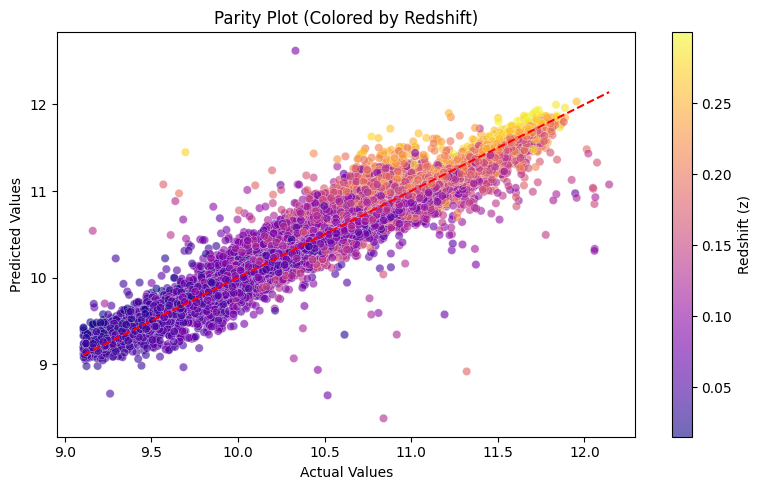

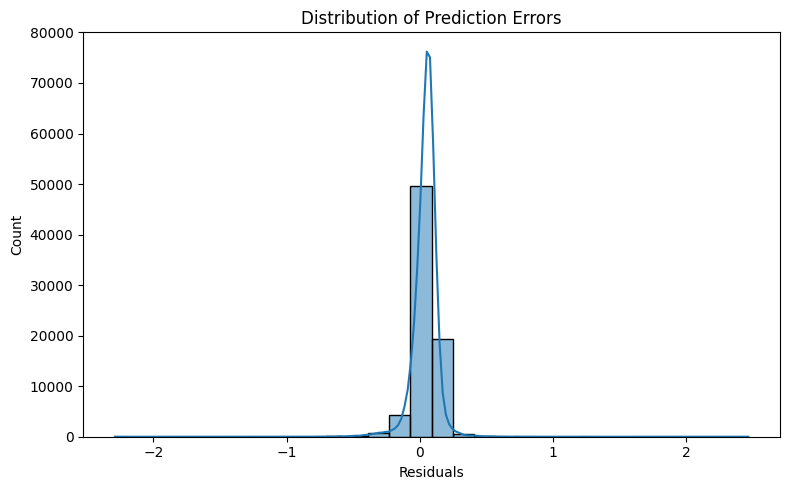

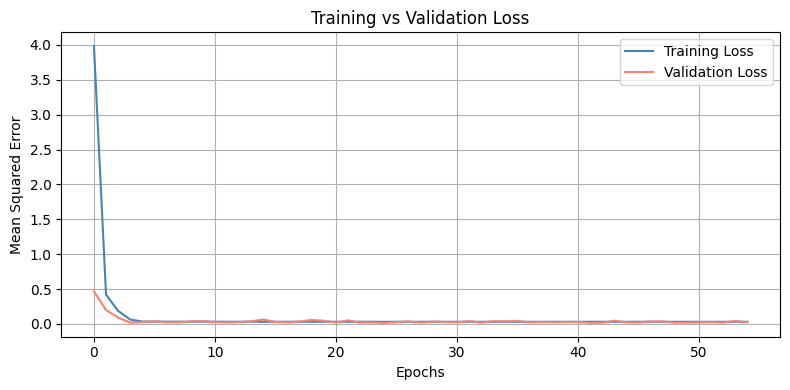

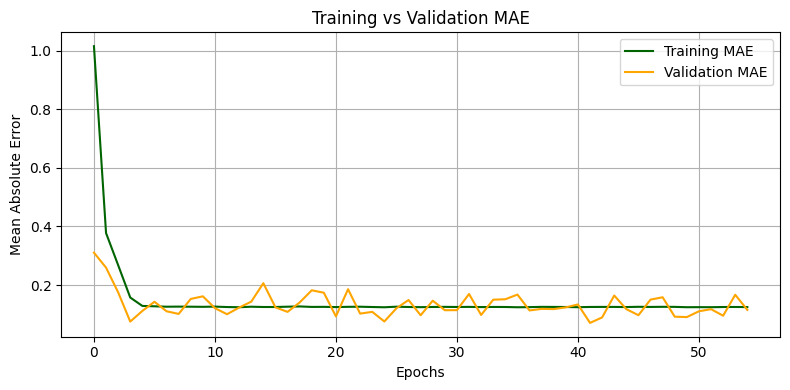

In [20]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)

### Photometry Transfer Learned Model

In [21]:
os.makedirs('output/photo_transfer_learned', exist_ok=True)

In [22]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols].copy()
y = df[target_col].copy()

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'output/photo_transfer_learned/scaler.pkl')

['output/photo_transfer_learned/scaler.pkl']

In [25]:
# Input shape
input_shape = X_train_scaled.shape[1]
optimizer = Adam(learning_rate=0.001)

# Input layer
inputs = keras.Input(shape=(input_shape,), name='Input')

# 🔄 Projection layer to align reduced input space
x = layers.Dense(128, activation='relu', name='Projection')(inputs)

# Layer 1 (frozen)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(x)
x = layers.Dropout(0.1, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 2 (partially unfrozen)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.1, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 3 (trainable)
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_new')(x)
x = layers.Dropout(0.1, name='Dropout_128_new')(x)
x = layers.BatchNormalization(name='BatchNorm_128_new')(x)
x = layers.Activation('relu', name='Activation_128_new')(x)

# 🔁 Residual connection with projection
shortcut = x  # shape (128,)
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_new')(x)
x = layers.Dropout(0.1, name='Dropout_64_new')(x)
x = layers.BatchNormalization(name='BatchNorm_64_new')(x)
x = layers.Activation('relu', name='Activation_64_new')(x)

# Project shortcut to match shape
shortcut_proj = layers.Dense(64, name='Shortcut_Projection')(shortcut)
x = layers.Add(name='Residual_Add')([x, shortcut_proj])

# Layer 5 (trainable)
x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), name='Dense_32_new')(x)
x = layers.Dropout(0.1, name='Dropout_32_new')(x)
x = layers.BatchNormalization(name='BatchNorm_32_new')(x)
x = layers.Activation('relu', name='Activation_32_new')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

# Model definition
model = keras.Model(inputs=inputs, outputs=outputs, name='Photo_Transfer_Learned_Regression_Model')

# Load weights from base model
model.load_weights('models/spectro_photo_base_regression_model.h5', by_name=True, skip_mismatch=True)

# Freeze reused layers
model.get_layer('Dense_64').trainable = False
model.get_layer('Dense_128').trainable = True  # Allow adaptation

# Compile with Huber loss
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
loss = tf.keras.losses.Huber(delta=1.0)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['mae', 'mse', 'mape'])

# Summary
model.summary()

Model: "Photo_Transfer_Learned_Regression_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 Projection (Dense)             (None, 128)          1408        ['Input[0][0]']                  
                                                                                                  
 Dense_64 (Dense)               (None, 64)           8256        ['Projection[0][0]']             
                                                                                                  
 Dropout_64 (Dropout)           (None, 64)           0           ['Dense_64[0][0]']               
                                                            

In [26]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
4383/4383 [==============================] - 40s 9ms/step - loss: 0.5748 - mae: 0.6860 - mse: 2.0876 - mape: 6.4157 - val_loss: 0.1358 - val_mae: 0.1352 - val_mse: 0.0383 - val_mape: 1.2597
Epoch 2/200
4383/4383 [==============================] - 39s 9ms/step - loss: 0.1798 - mae: 0.2662 - mse: 0.1505 - mape: 2.5130 - val_loss: 0.1259 - val_mae: 0.1617 - val_mse: 0.0535 - val_mape: 1.5319
Epoch 3/200
4383/4383 [==============================] - 39s 9ms/step - loss: 0.1440 - mae: 0.2107 - mse: 0.0955 - mape: 1.9950 - val_loss: 0.1022 - val_mae: 0.1059 - val_mse: 0.0187 - val_mape: 1.0004
Epoch 4/200
4383/4383 [==============================] - 40s 9ms/step - loss: 0.1096 - mae: 0.1465 - mse: 0.0405 - mape: 1.3900 - val_loss: 0.0922 - val_mae: 0.0710 - val_mse: 0.0106 - val_mape: 0.6728
Epoch 5/200
4383/4383 [==============================] - 37s 8ms/step - loss: 0.0974 - mae: 0.1113 - mse: 0.0224 - mape: 1.0539 - val_loss: 0.0974 - val_mae: 0.1204 - val_mse: 0.0227 - val_map

In [27]:
model.save('output/photo_transfer_learned/model.h5')

In [28]:
y_pred = model.predict(X_test_scaled)

2349/2349 [==============================] - 6s 2ms/step


In [29]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0484 dex
Root Mean Squared Error (RMSE): 0.0807 dex
R² Score: 0.9732
Fraction within ±0.20 dex: 97.09%


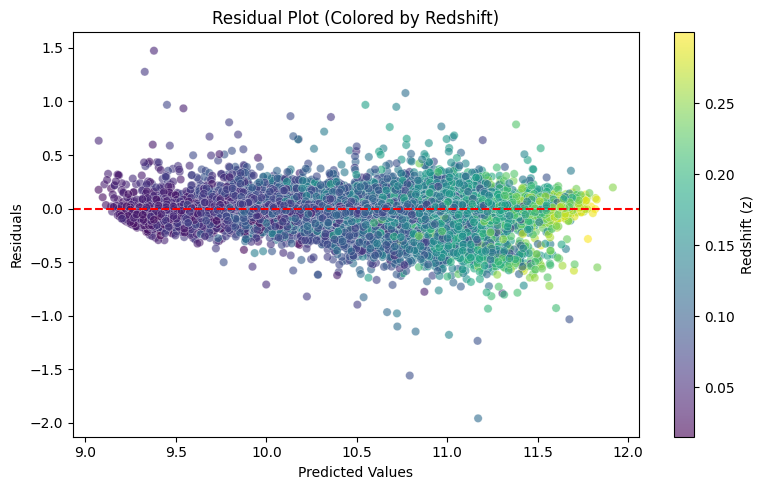

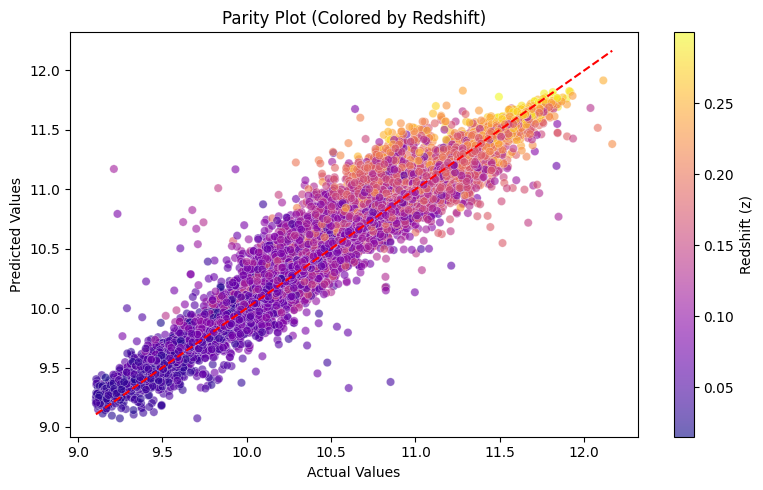

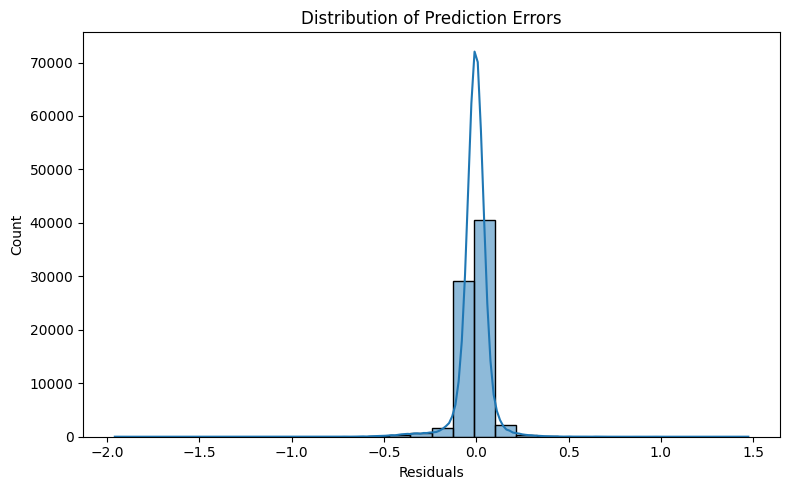

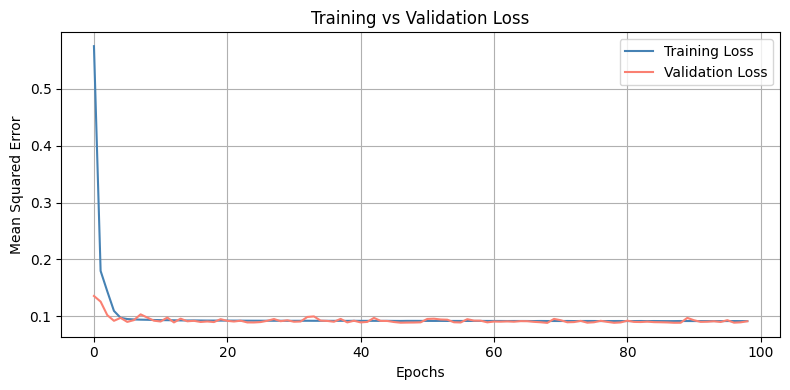

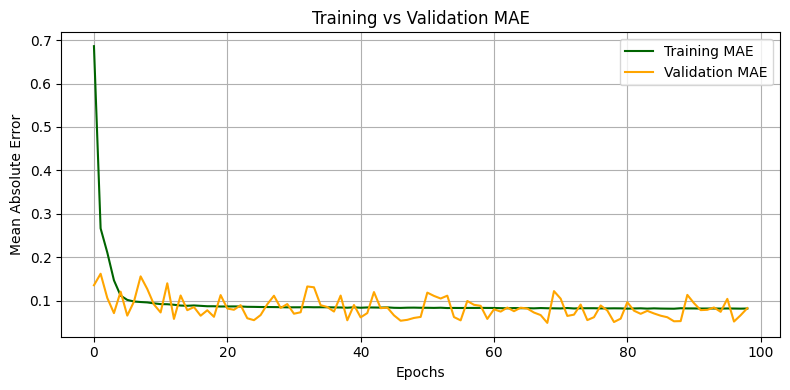

In [30]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)

### Photo No Transfer Learning Model

In [31]:
os.makedirs('output/photo_no_transfer', exist_ok=True)

In [32]:
df = pd.read_csv(f"data/processed/photometry_only.csv")

X = df[photo_cols + generic_cols].copy()
y = df[target_col].copy()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [34]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'output/photo_no_transfer/scaler.pkl')

['output/photo_no_transfer/scaler.pkl']

In [35]:
# Input Layer
input_shape = X_train_scaled.shape[1]
optimizer = Adam(learning_rate=0.001)

inputs = keras.Input(shape=(input_shape,), name='Input')

# Layer 1
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(inputs)
x = layers.Dropout(0.2, name='Dropout_64')(x)
x = layers.BatchNormalization(name='BatchNorm_64')(x)
x = layers.Activation('relu', name='Activation_64')(x)

# Layer 2
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(x)
x = layers.Dropout(0.2, name='Dropout_128')(x)
x = layers.BatchNormalization(name='BatchNorm_128')(x)
x = layers.Activation('relu', name='Activation_128')(x)

# Layer 3
x = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), name='Dense_256')(x)
x = layers.Dropout(0.2, name='Dropout_256')(x)
x = layers.BatchNormalization(name='BatchNorm_256')(x)
x = layers.Activation('relu', name='Activation_256')(x)

# Layer 4
x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128_2')(x)
x = layers.Dropout(0.2, name='Dropout_128_2')(x)
x = layers.BatchNormalization(name='BatchNorm_128_2')(x)
x = layers.Activation('relu', name='Activation_128_2')(x)

# Layer 5
x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64_2')(x)
x = layers.Dropout(0.2, name='Dropout_64_2')(x)
x = layers.BatchNormalization(name='BatchNorm_64_2')(x)
x = layers.Activation('relu', name='Activation_64_2')(x)

# Output layer
outputs = layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Photo_No_Transfer_Learning_Regression_Model')

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.mean_squared_error,
              metrics=['mae', 'mse', 'mape'])

model.summary()

Model: "Photo_No_Transfer_Learning_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10)]              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                704       
                                                                 
 Dropout_64 (Dropout)        (None, 64)                0         
                                                                 
 BatchNorm_64 (BatchNormaliz  (None, 64)               256       
 ation)                                                          
                                                                 
 Activation_64 (Activation)  (None, 64)                0         
                                                                 
 Dense_128 (Dense)           (None, 128)               8320      
                       

In [36]:
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
4383/4383 [==============================] - 41s 9ms/step - loss: 3.5699 - mae: 0.9774 - mse: 3.1038 - mape: 9.1556 - val_loss: 0.5829 - val_mae: 0.3548 - val_mse: 0.2613 - val_mape: 3.2628
Epoch 2/200
4383/4383 [==============================] - 39s 9ms/step - loss: 0.4341 - mae: 0.3923 - mse: 0.2531 - mape: 3.6868 - val_loss: 0.2273 - val_mae: 0.2772 - val_mse: 0.1306 - val_mape: 2.5622
Epoch 3/200
4383/4383 [==============================] - 39s 9ms/step - loss: 0.2081 - mae: 0.2823 - mse: 0.1385 - mape: 2.6581 - val_loss: 0.0932 - val_mae: 0.1625 - val_mse: 0.0482 - val_mape: 1.5435
Epoch 4/200
4383/4383 [==============================] - 39s 9ms/step - loss: 0.0764 - mae: 0.1694 - mse: 0.0518 - mape: 1.6020 - val_loss: 0.0205 - val_mae: 0.0779 - val_mse: 0.0120 - val_mape: 0.7362
Epoch 5/200
4383/4383 [==============================] - 39s 9ms/step - loss: 0.0346 - mae: 0.1283 - mse: 0.0286 - mape: 1.2163 - val_loss: 0.0267 - val_mae: 0.1004 - val_mse: 0.0211 - val_map

In [37]:
model.save('output/photo_no_transfer/model.h5')

In [38]:
y_pred = model.predict(X_test_scaled)

2349/2349 [==============================] - 9s 4ms/step


In [39]:
plot_metrics(y_test, y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0629 dex
Root Mean Squared Error (RMSE): 0.0972 dex
R² Score: 0.9611
Fraction within ±0.20 dex: 96.10%


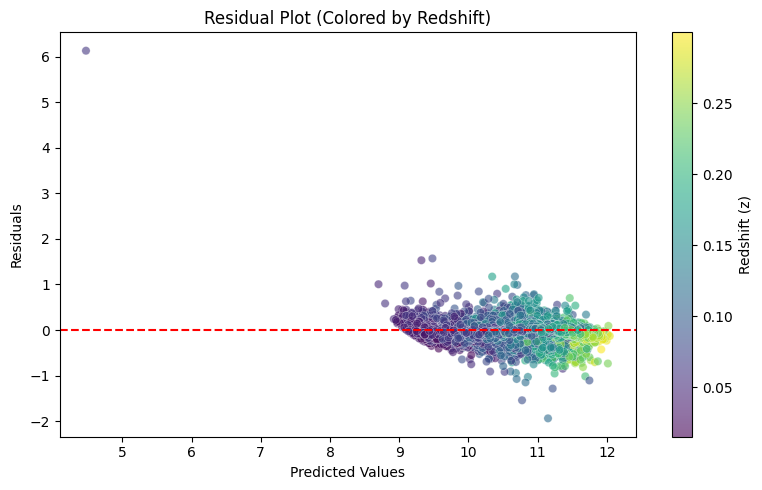

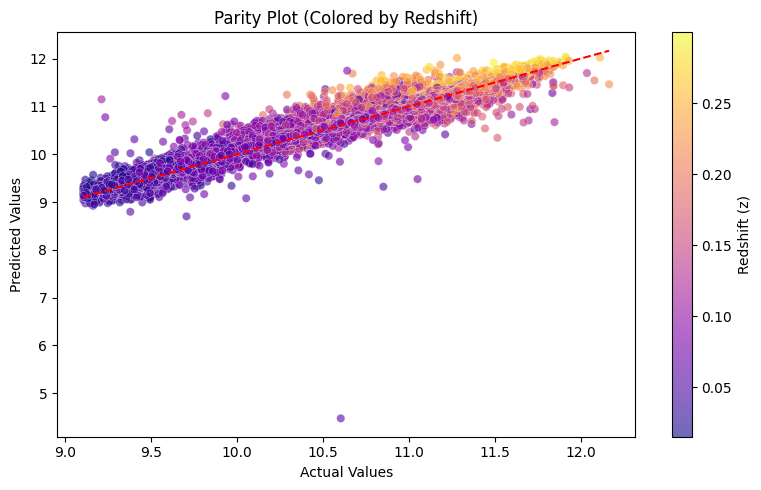

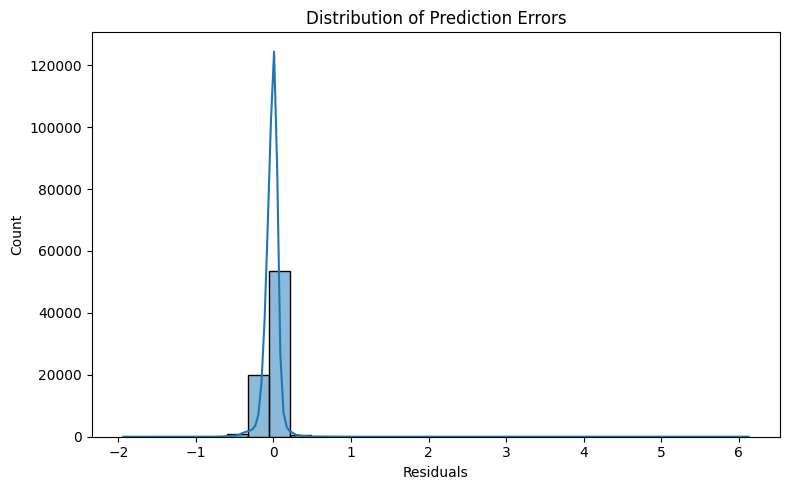

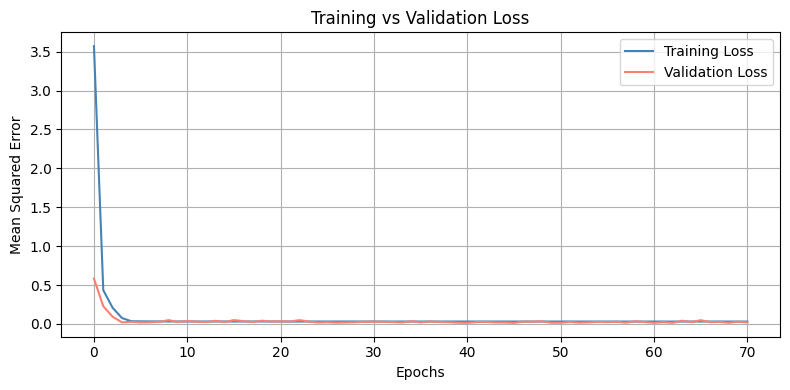

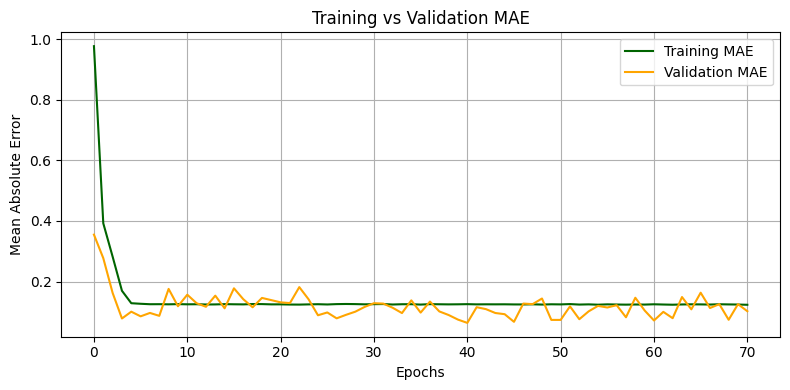

In [40]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)

# Method 2: Feature Importance Analysis

### Feature Importance Analysis

In [41]:
df = pd.read_csv('data/processed/cleaned_data.csv')

X = df[spectro_cols + photo_cols + generic_cols].copy()
y = df[target_col].copy()

In [42]:
# Train/Val Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Normalize inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

C:\Users\Sahil\AppData\Local\Temp\ipykernel_37796\688112782.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_scaled, y_train)


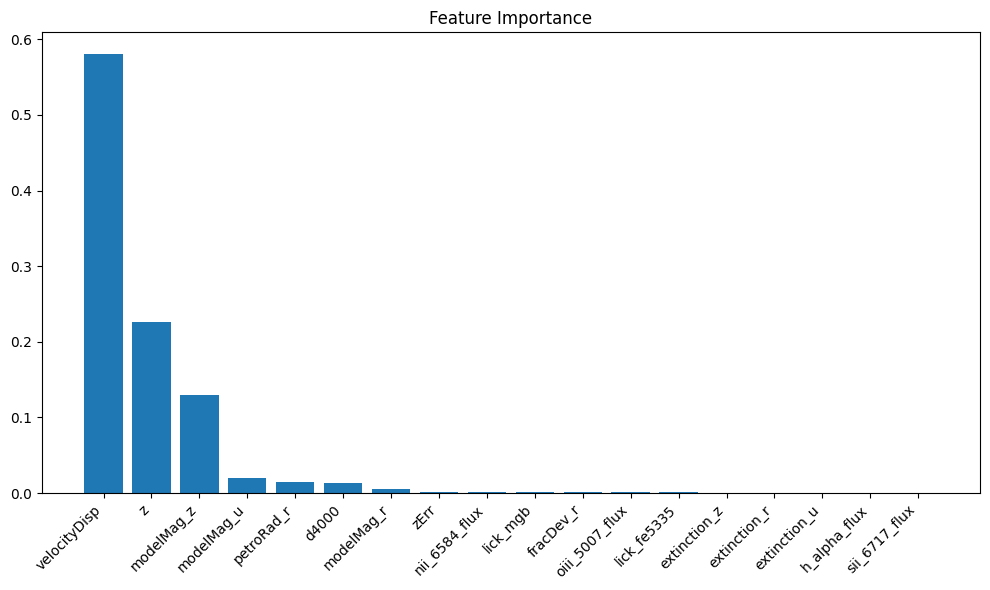

In [45]:
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], align='center')
plt.xticks(range(len(importances)), np.array(spectro_cols+photo_cols+generic_cols)[sorted_idx], rotation=45, ha='right')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [46]:
plot_metrics(np.squeeze(y_test), y_pred)

📊 Evaluation Metrics:
Mean Absolute Error (MAE): 0.0455 dex
Root Mean Squared Error (RMSE): 0.0789 dex
R² Score: 0.9741
Fraction within ±0.20 dex: 97.12%


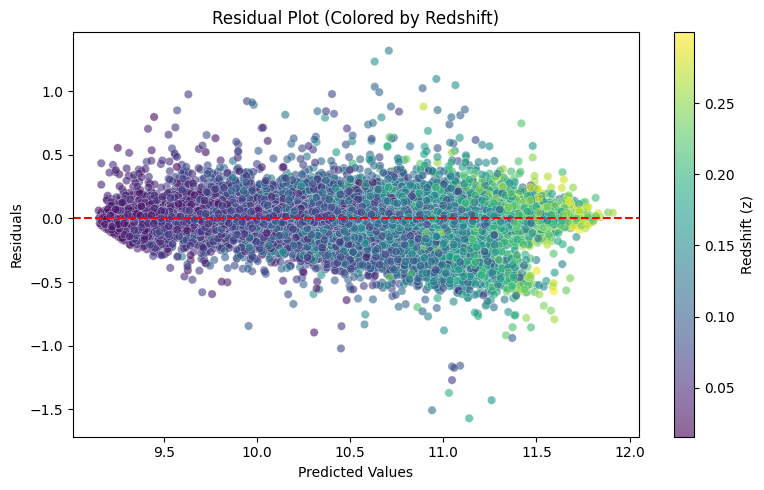

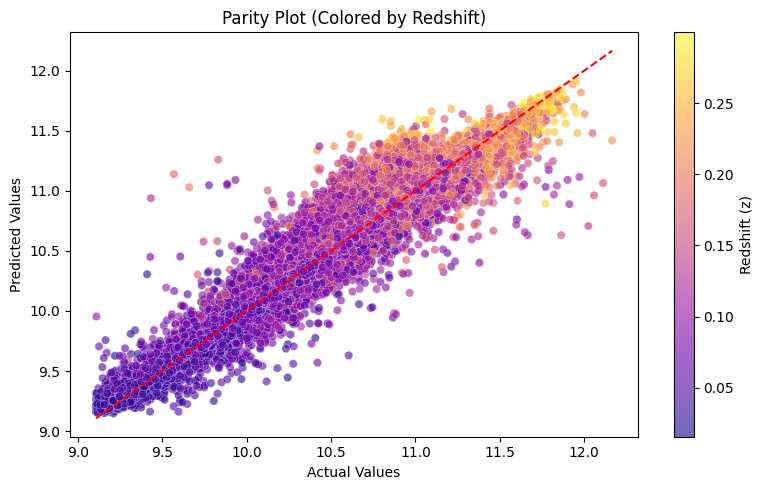

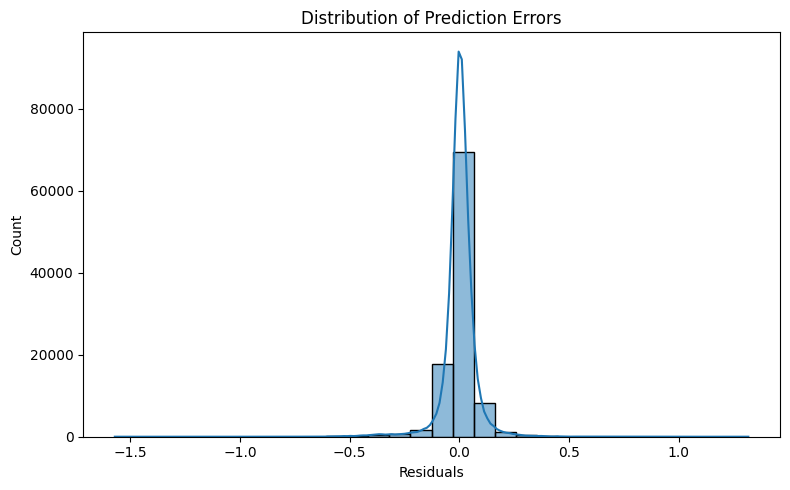

In [47]:
plot_visualizations(y_test, y_pred, z_values=X_test['z'])

### n-Top Features Neural Network

In [50]:
os.makedirs('output/top_n_features_neural_network', exist_ok=True)

In [51]:
top_features = X_train.columns[np.argsort(rf.feature_importances_)[::-1][:12]]

Model: "Top_6_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 6)]               0         
                                                                 
 Dense_128 (Dense)           (None, 128)               896       
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                   

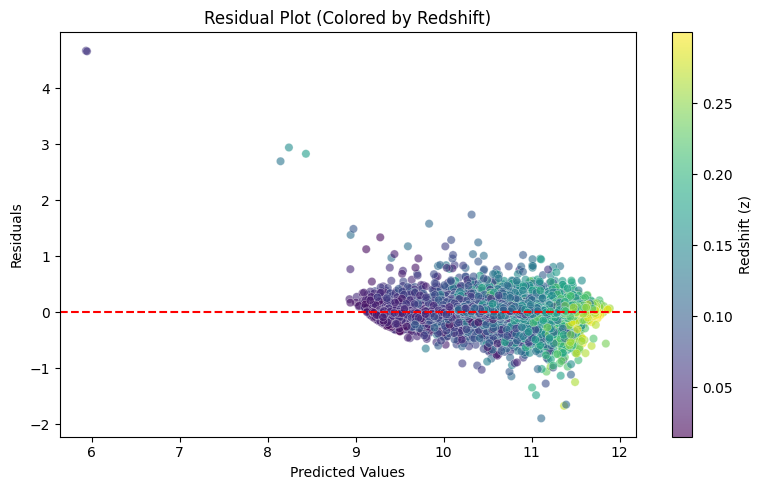

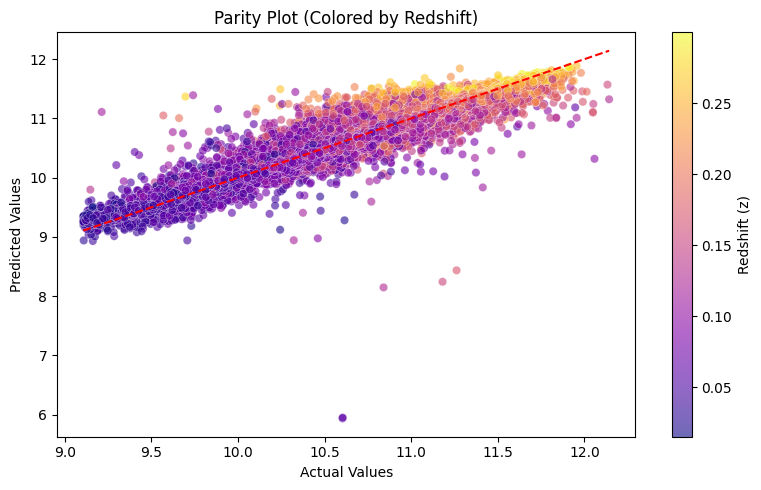

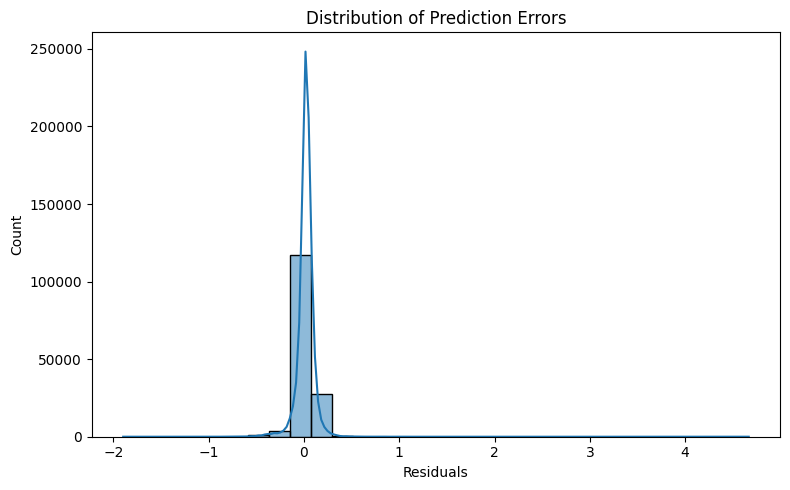

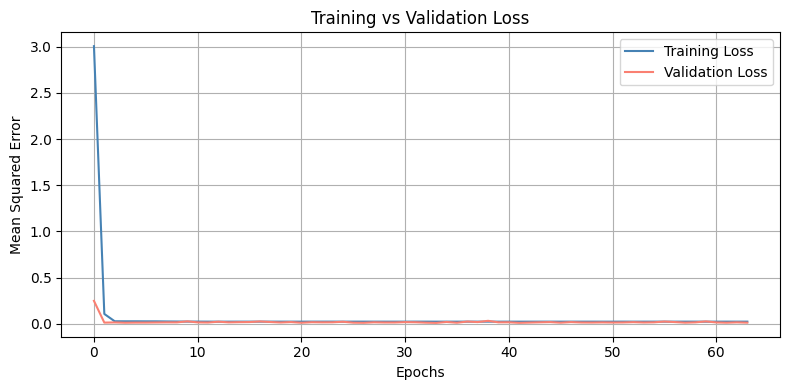

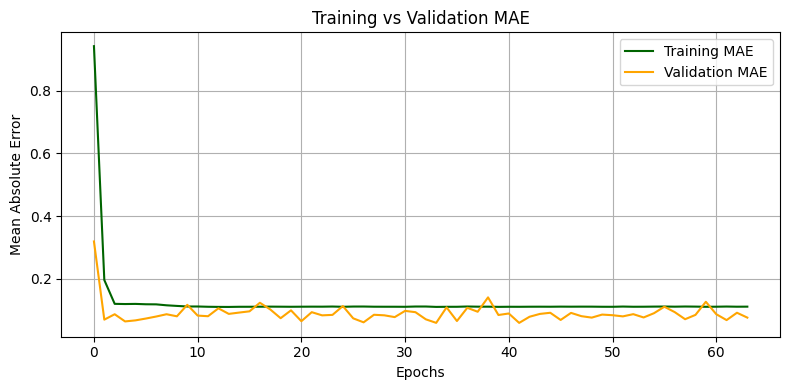

Model: "Top_7_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 7)]               0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1024      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                   

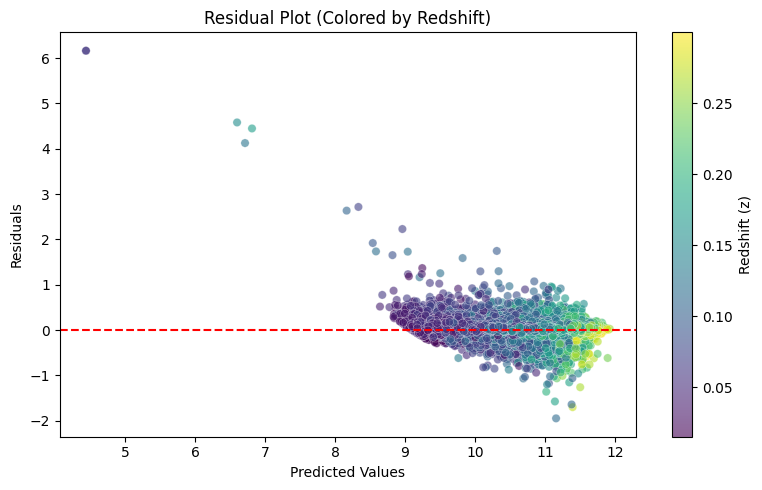

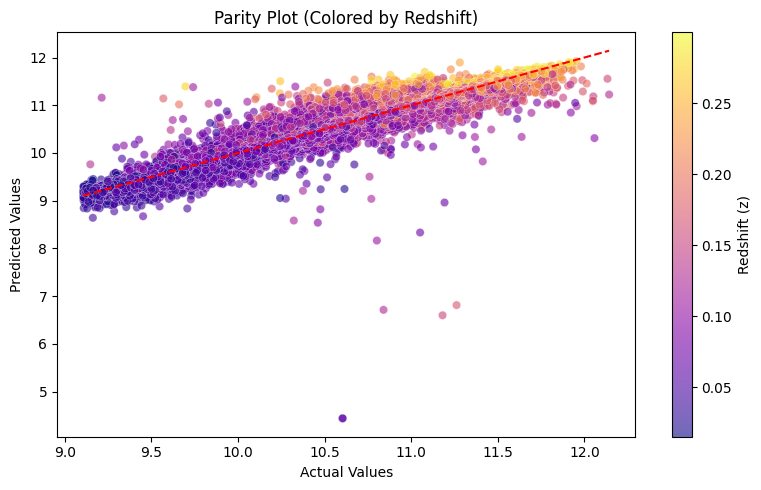

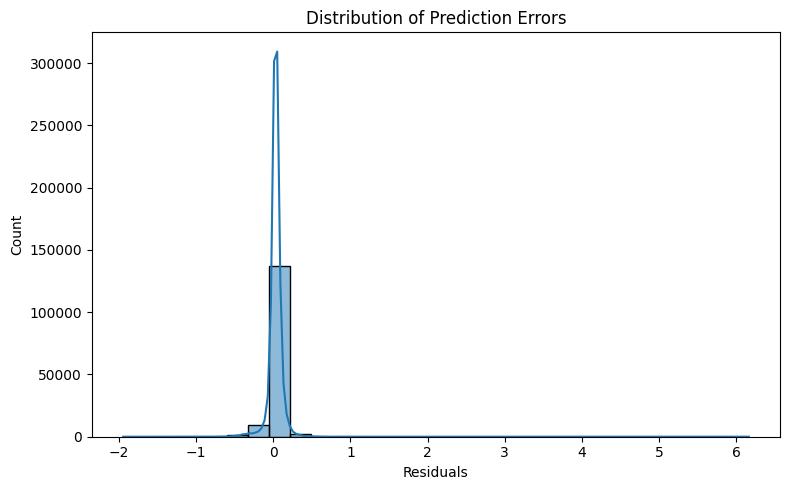

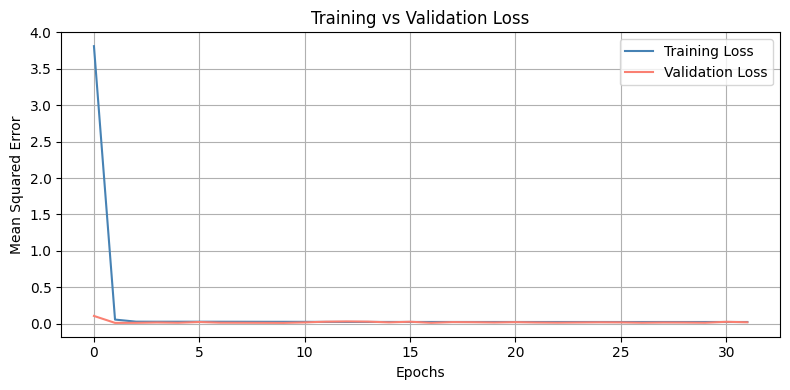

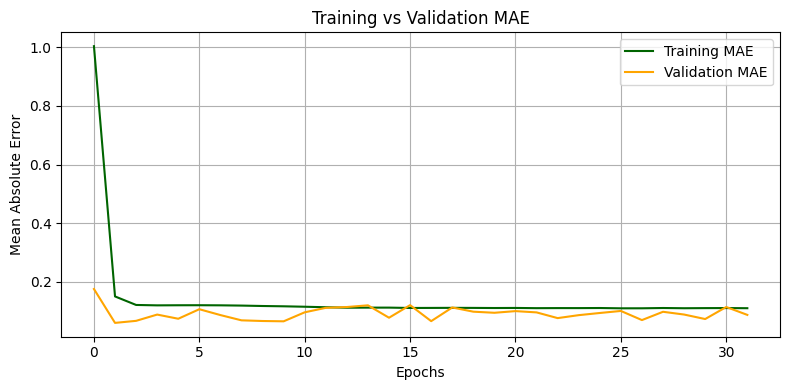

Model: "Top_8_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 8)]               0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1152      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                   

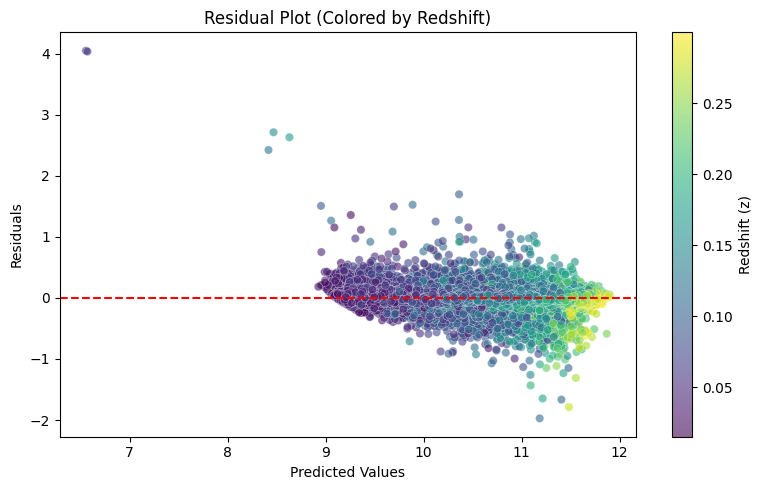

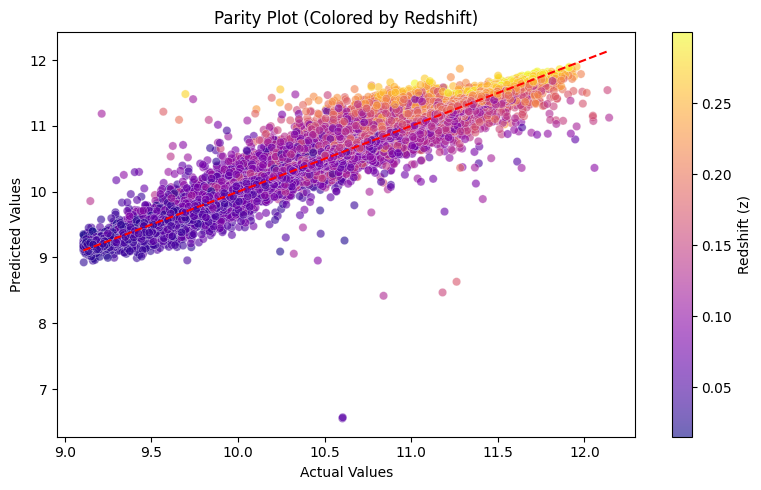

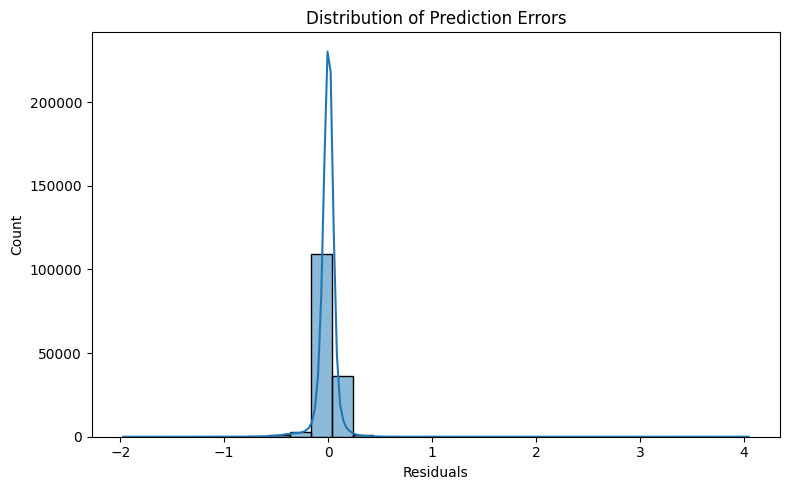

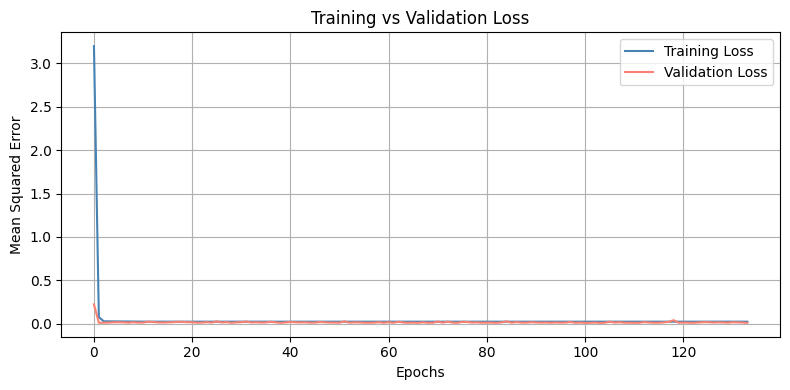

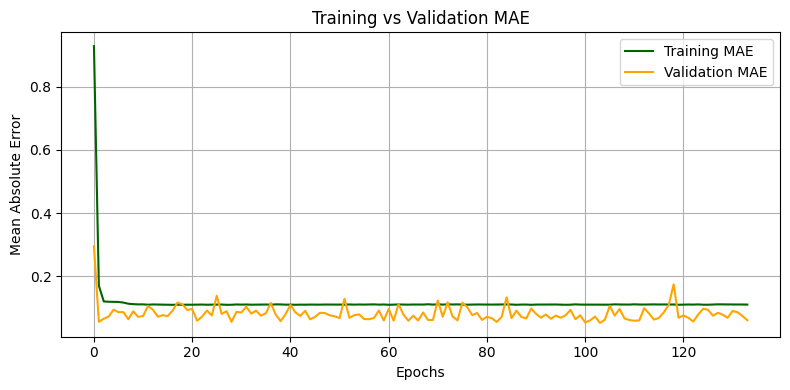

Model: "Top_9_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 9)]               0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1280      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                   

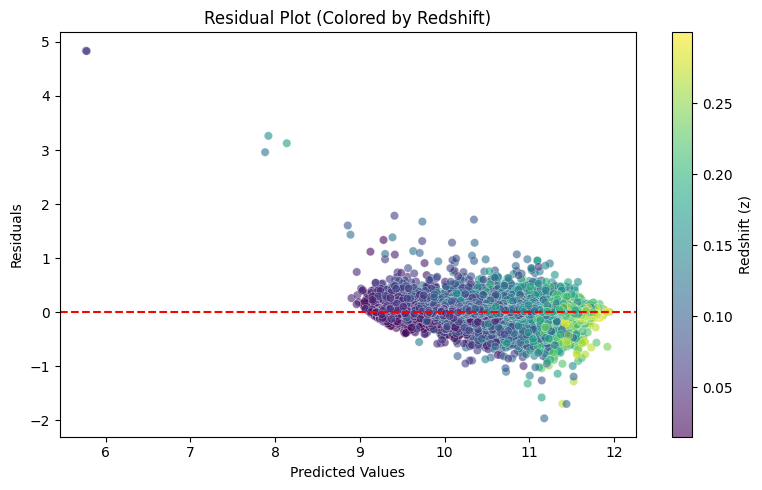

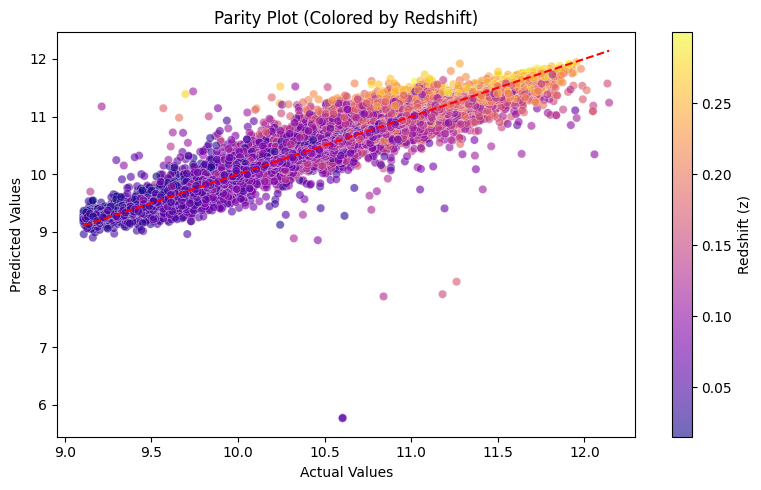

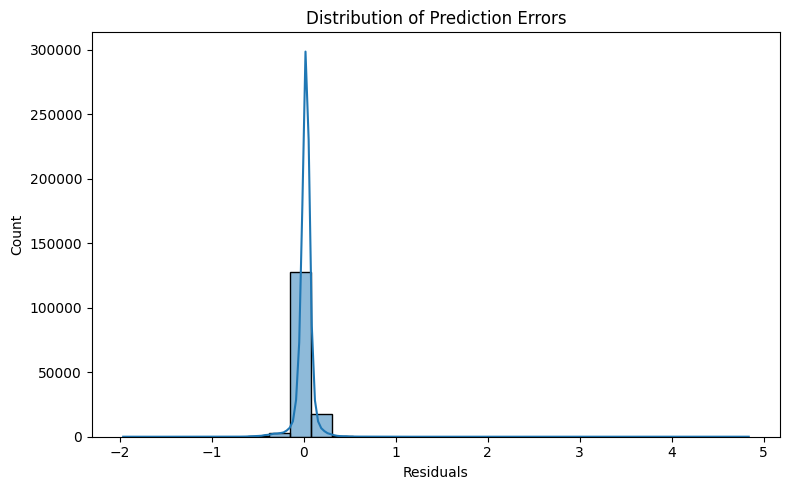

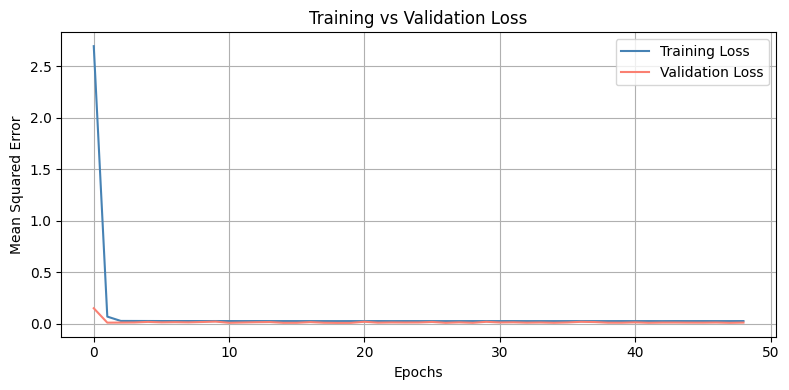

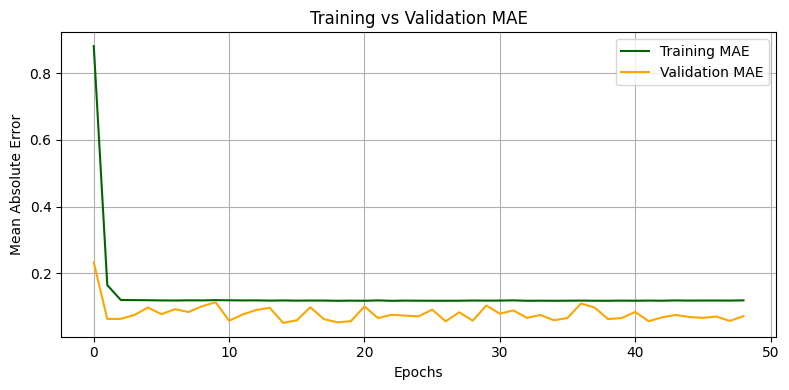

Model: "Top_10_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 10)]              0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1408      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                  

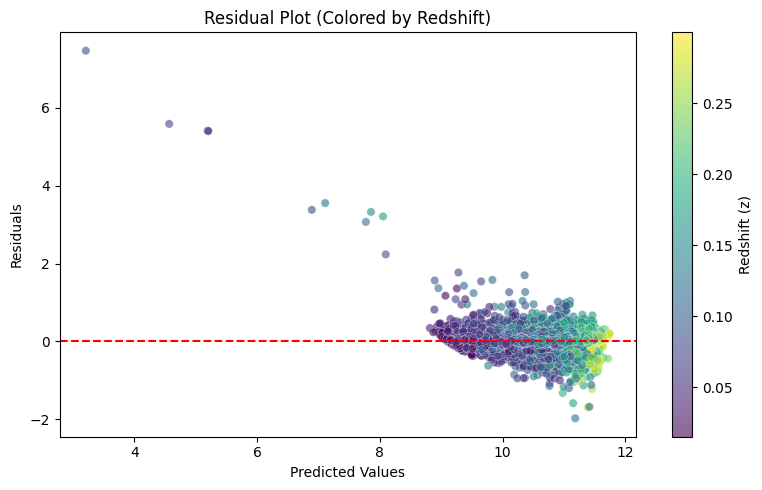

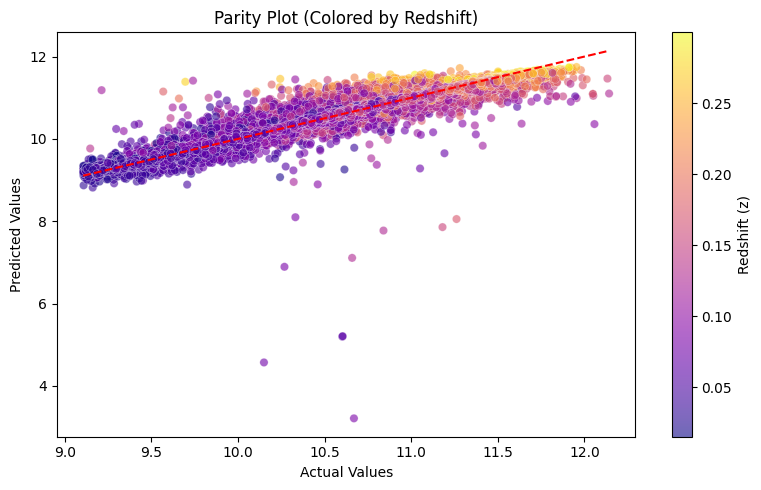

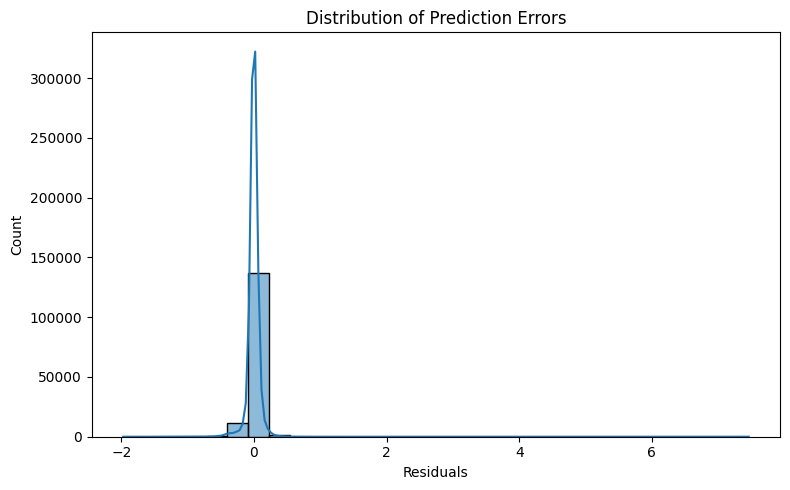

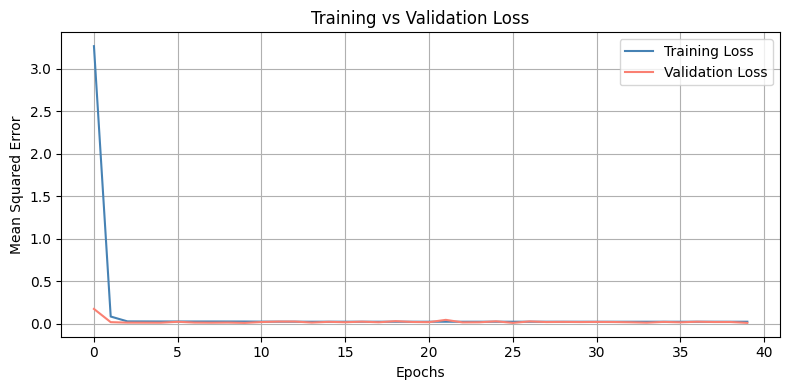

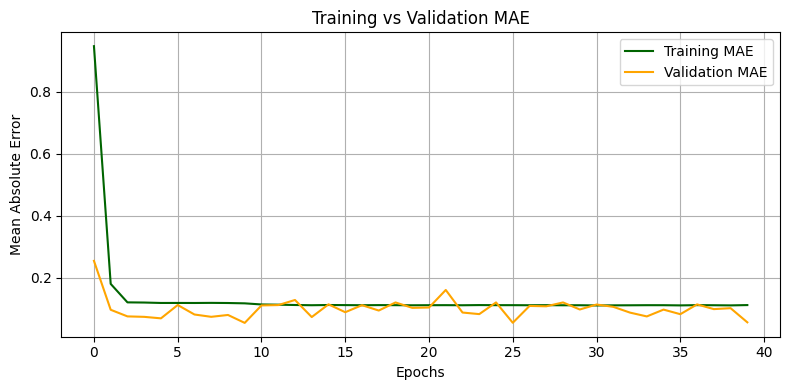

Model: "Top_11_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 11)]              0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1536      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                  

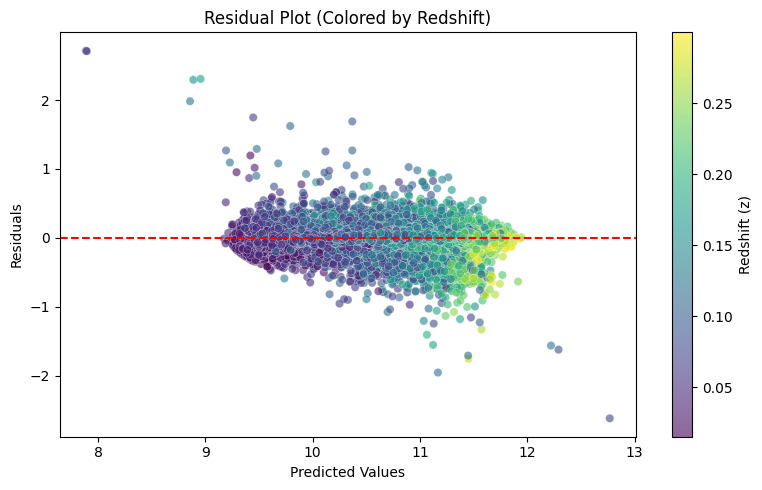

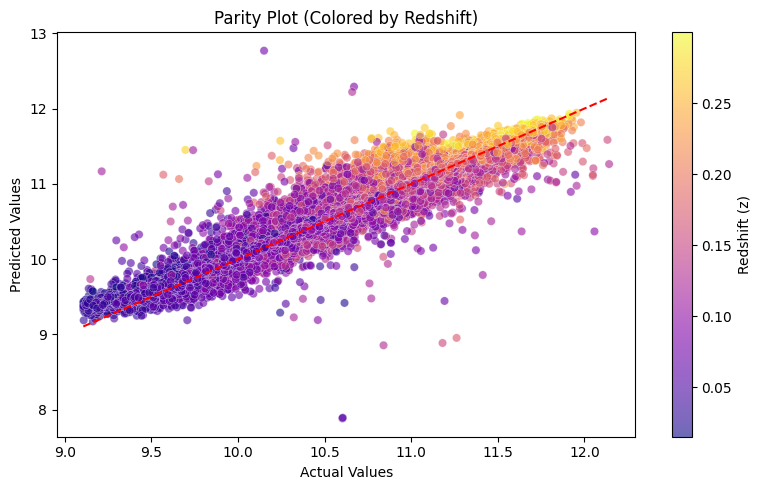

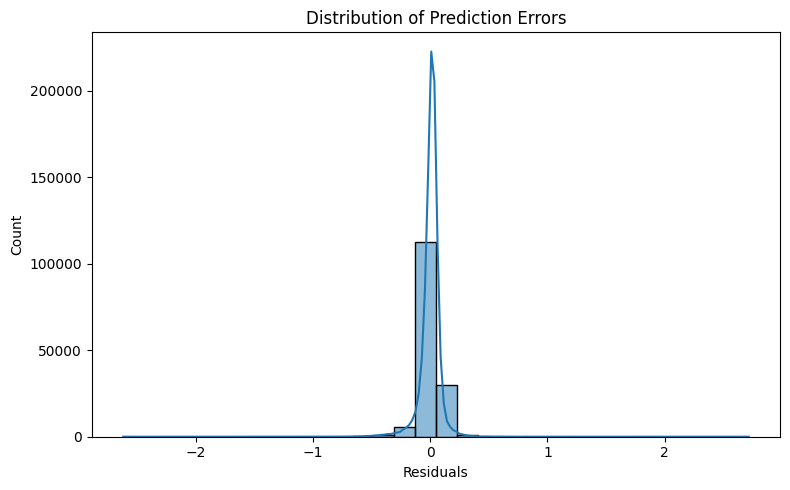

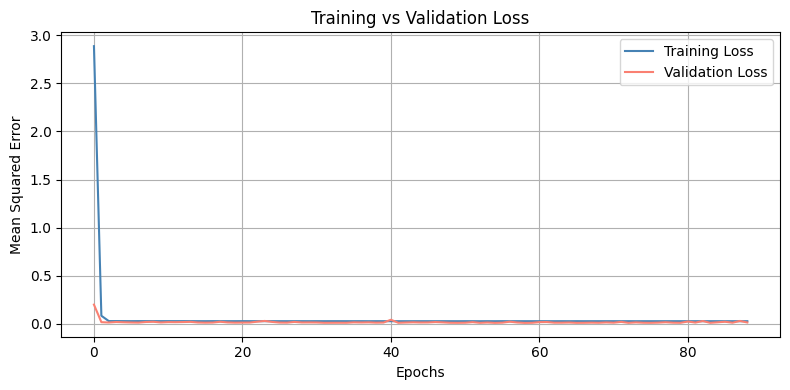

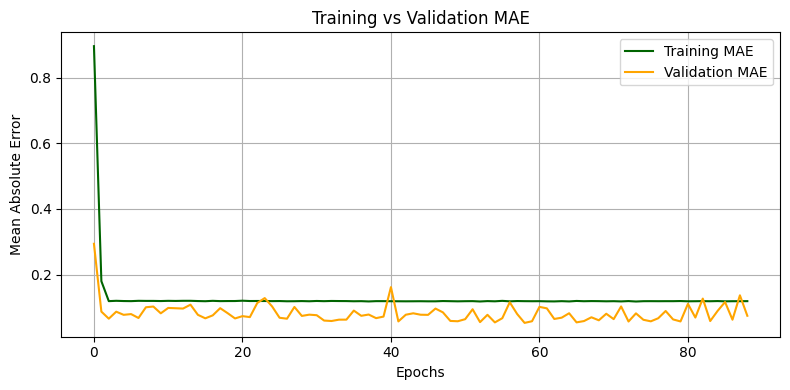

Model: "Top_12_Features_Regression_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 12)]              0         
                                                                 
 Dense_128 (Dense)           (None, 128)               1664      
                                                                 
 Dropout_128 (Dropout)       (None, 128)               0         
                                                                 
 BatchNorm_128 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 Activation_128 (Activation)  (None, 128)              0         
                                                                 
 Dense_64 (Dense)            (None, 64)                8256      
                                  

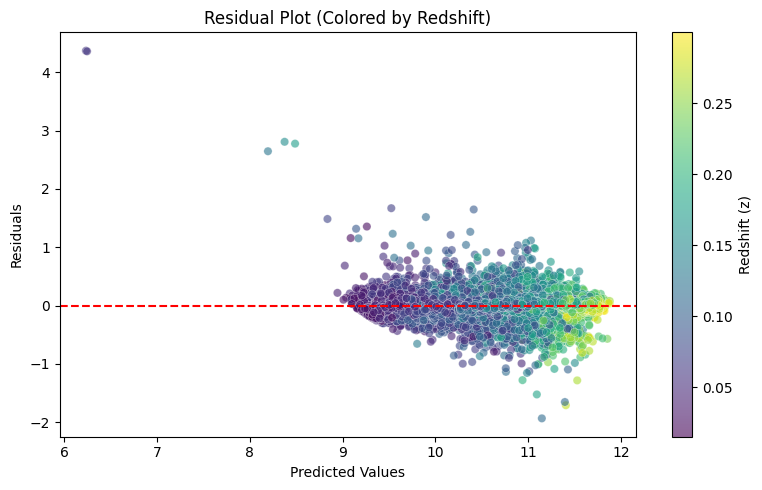

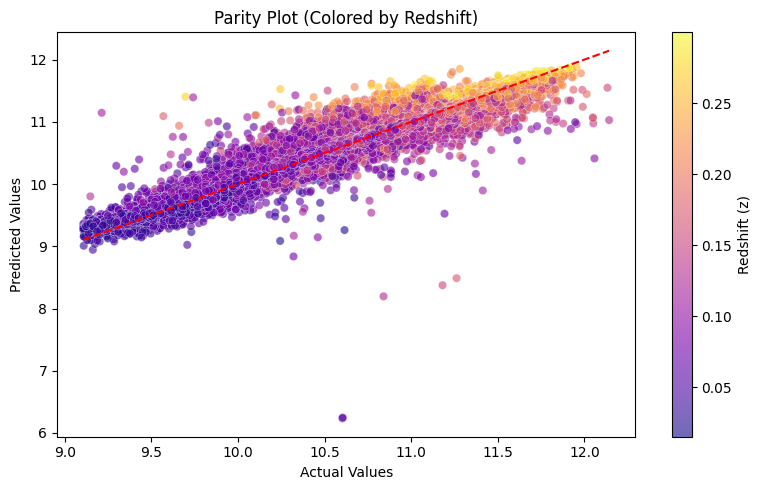

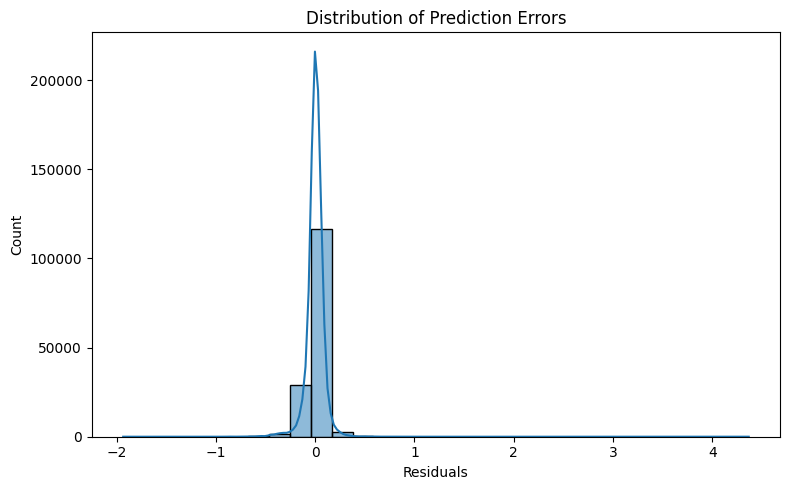

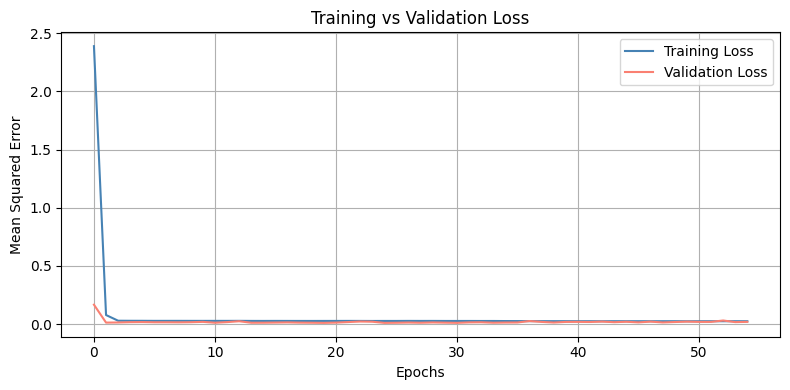

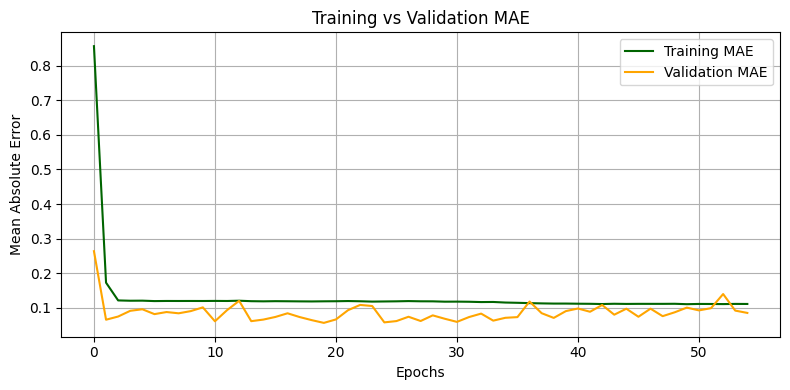

In [52]:
df = pd.read_csv('data/processed/cleaned_data.csv')

for i in range(6,13, 1):
    X = df[top_features[:i]].copy()
    y = df[target_col].copy()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    input_shape = X_train_scaled.shape[1]

    optimizer = Adam(learning_rate=0.001)

    inputs = keras.Input(shape=(input_shape,), name='Input')

    # Layer 1
    x = layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), name='Dense_128')(inputs)
    x = layers.Dropout(0.2, name='Dropout_128')(x)
    x = layers.BatchNormalization(name='BatchNorm_128')(x)
    x = layers.Activation('relu', name='Activation_128')(x)

    # Layer 2
    x = layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), name='Dense_64')(x)
    x = layers.Dropout(0.2, name='Dropout_64')(x)
    x = layers.BatchNormalization(name='BatchNorm_64')(x)
    x = layers.Activation('relu', name='Activation_64')(x)

    # Layer 3
    x = layers.Dense(32, kernel_regularizer=regularizers.l2(0.001), name='Dense_32')(x)
    x = layers.Dropout(0.2, name='Dropout_32')(x)
    x = layers.BatchNormalization(name='BatchNorm_32')(x)
    x = layers.Activation('relu', name='Activation_32')(x)

    # Output
    outputs = layers.Dense(1, name='Output')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name=f'Top_{i}_Features_Regression_Model')

    # Compile
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    model.compile(optimizer=optimizer, 
                loss=tf.keras.losses.mean_squared_error, 
                metrics=['mae', 'mse', 'mape'])

    model.summary()


    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    model.save(f'output/top_n_features_neural_network/top_{i}_features_regression_model.h5')
    
    y_pred = model.predict(X_test_scaled)
    print(f"Metrics for top {i} features model:")
    plot_metrics(y_test, y_pred)
    print(f"Visualizations for top {i} features model:")
    plot_visualizations(y_test, y_pred, z_values=X_test['z'], history=history)
